In [1]:
!pip install --quiet transformers seaborn datasets evaluate rouge_score nltk numpy spacy lexrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.5 MB/s eta 0:00:

In [2]:
!pip install --quiet --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 9.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp "/content/drive/MyDrive/RuSportSum/train_after_match_pairs_data2.csv" /content/train.csv
!cp "/content/drive/MyDrive/RuSportSum/eval_after_match_pairs_data2.csv" /content/eval.csv
!cp "/content/drive/MyDrive/RuSportSum/test_after_match_pairs_data2.csv" /content/test.csv

In [5]:
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from lexrank import LexRank
from spacy.lang.ru.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
from datasets import Dataset
from datasets import load_dataset, load_metric
from sklearn.model_selection import train_test_split
import transformers
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    HfArgumentParser,
    MBart50TokenizerFast,
    MBartTokenizer,
    MBartTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)
import evaluate

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
train = pd.read_csv('/content/train.csv')
eval = pd.read_csv('/content/eval.csv')
test = pd.read_csv('/content/test.csv')
train

,match_id,news_id,name,team1,team2,content,news_name,news_body,news_name_body
0,965329,1029966958,Германия. Бундеслига,Бавария,Майнц,25 минута. гол! Левандовски открывает счет! Бь...,«Бавария» – «Майнц» – 2:0. Швайнштайгер постав...,В 34-м туре бундеслиги «Бавария» обыграла «Май...,«Бавария» – «Майнц» – 2:0. Швайнштайгер постав...
1,907948,159287107,Кубок Гагарина,Локомотив,Лев,25 минута. НОВОТНЫ - 0:1!!! 4-й гол в плей-офф...,КХЛ. Кубок Гагарина. 1/2 финала. Четвертый мат...,Сегодня в четвертом матче финала Западной конф...,КХЛ. Кубок Гагарина. 1/2 финала. Четвертый мат...
2,965186,1026902126,Германия. Бундеслига,Байер,Боруссия Д,13 минута. Дрмич получил первое предупреждение...,«Байер» – «Боруссия» Дортмунд – 0:0. Команды г...,Сегодня в рамках 18-го тура чемпионата Германи...,«Байер» – «Боруссия» Дортмунд – 0:0. Команды г...
3,1035457,1040243081,Россия. Премьер-лига,Ахмат,Ростов,24 минута. А вот и анонсированная замена. Вмес...,«Терек» – «Ростов» – 0:2. Ерохин установил око...,В 30-м туре премьер-лиги «Терек» уступил «Рост...,«Терек» – «Ростов» – 0:2. Ерохин установил око...
4,490290,143886070,Франция. Лига 1,Марсель,ПСЖ,"17 минута. гол! 1:0! Угловой у ворот хозяев, н...",«Марсель» – «ПСЖ» – 2:2. Жиньяк сравнял счет,Лидер французского чемпионата «Марсель» на «Ве...,«Марсель» – «ПСЖ» – 2:2. Жиньяк сравнял счет &...
...,...,...,...,...,...,...,...,...,...
7594,829996,1021343013,Чемпионат мира,Англия,Италия,35 минута. гол! 0:1! Маркизио! Разыграли углов...,Англия – Италия – 1:2. Балотелли забил победны...,Сегодня в 1-м туре чемпионата мира-2014 на ста...,Англия – Италия – 1:2. Балотелли забил победны...
7595,830027,1021785801,Чемпионат мира,Голландия,Мексика,9 минута. Ничего себе начало! Мы только начали...,Голландия – Мексика. Голландцы впервые за 26 м...,Сборная Голландии сегодня обыграла команду Мек...,Голландия – Мексика. Голландцы впервые за 26 м...
7596,775308,147870527,Кубок Гагарина,Трактор,Ак Барс,4 минута. НИЧУШКИН - 1:0!!!!! 6-й гол в плей-о...,КХЛ. Кубок Гагарина. 1/2 финала. «Трактор» в о...,Сегодня в четвертом матче полуфинальной серии ...,КХЛ. Кубок Гагарина. 1/2 финала. «Трактор» в о...
7597,814916,153516257,КХЛ,Барыс,Динамо Москва,22 минута. ЦВЕТКОВ - 0:1!!! 4-й гол в сезоне! ...,«Барыс» – «Динамо» – 4:3 Б. Хозяева одержали в...,Сегодня в рамках очередного матча регулярного ...,«Барыс» – «Динамо» – 4:3 Б. Хозяева одержали в...


In [7]:
data = pd.concat([train, eval, test])
data['len_content'] = data['content'].apply(lambda x: len(str(x).split()))
data['len_news_name_body'] = data['news_name_body'].apply(lambda x: len(str(x).split()))
data[['len_content', 'len_news_name_body']].describe()

,len_content,len_news_name_body
count,8749.000000,8749.000000
mean,338.081724,59.711167
std,164.875614,25.922776
min,0.000000,8.000000
25%,235.000000,40.000000
50%,301.000000,55.000000
75%,401.000000,73.000000
max,1694.000000,401.000000


<Axes: xlabel='len_news_name_body'>

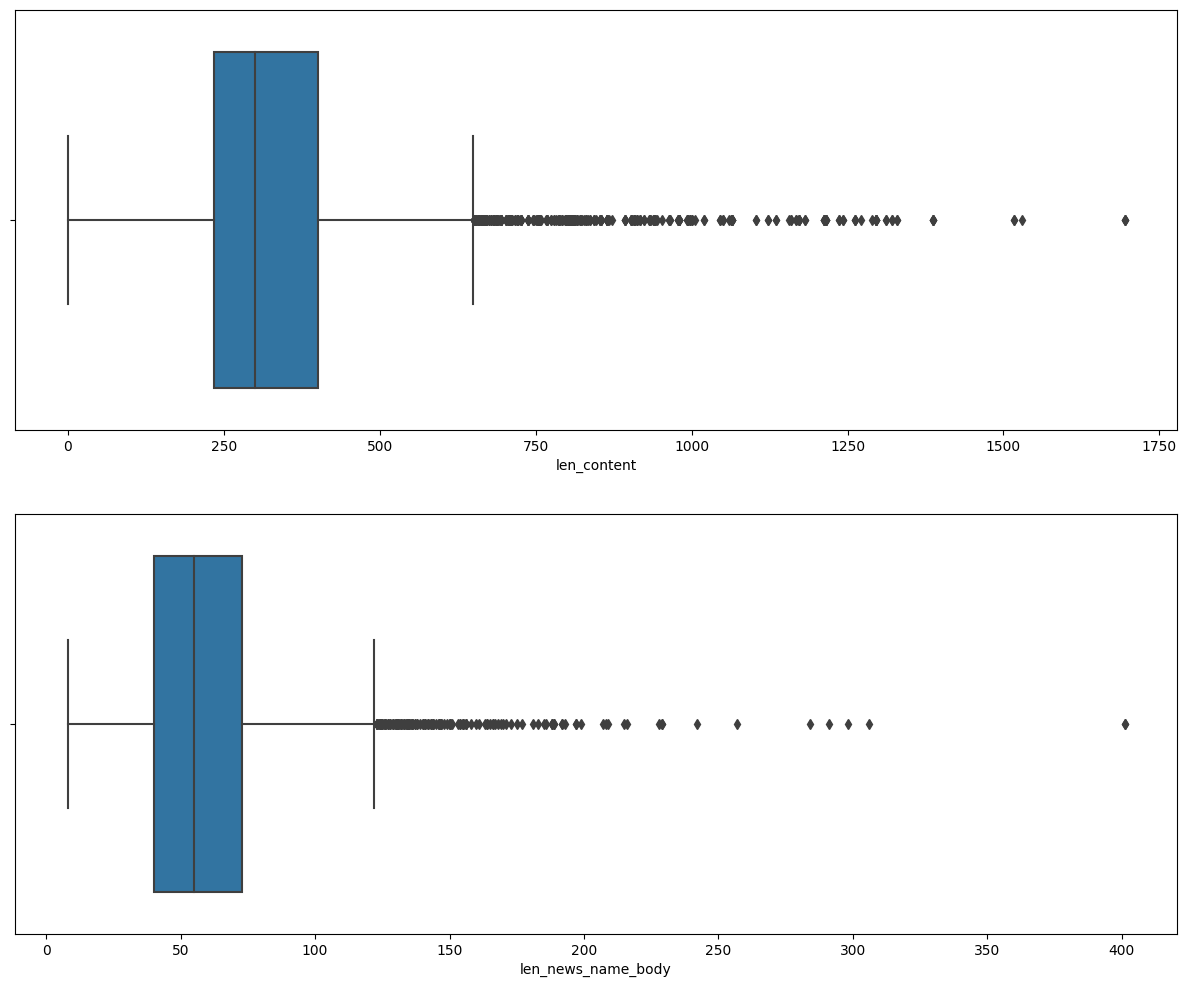

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

sns.boxplot(ax=axes[0], x='len_content', data=data)
sns.boxplot(ax=axes[1], x='len_news_name_body', data=data)

In [9]:
def change_size(row):
  row = str(row)
  words = row.split()
  if len(words) > 400:
    return ' '.join(words[len(words) - 400:])
  return row

train['content'] = train['content'].apply(change_size)
eval['content'] = eval['content'].apply(change_size)
test['content'] = test['content'].apply(change_size)

In [10]:
train.to_csv('train.csv', index=False, encoding='utf-8')
eval.to_csv('eval.csv', index=False, encoding='utf-8')
test.to_csv('test.csv', index=False, encoding='utf-8')

In [11]:
train['len_content'] = train['content'].apply(lambda x: len(str(x).split()))
train['len_news_name_body'] = train['news_name_body'].apply(lambda x: len(str(x).split()))
train[['len_content', 'len_news_name_body']].describe()

,len_content,len_news_name_body
count,7599.000000,7599.000000
mean,300.118042,59.798395
std,85.014336,26.023703
min,0.000000,8.000000
25%,235.000000,40.000000
50%,301.000000,55.000000
75%,400.000000,73.000000
max,400.000000,401.000000


### Обобщающие новости

#### Fine-tuning модели mbart-large-cc25

In [12]:
SEED = 3
lang = 'ru_RU'
set_seed(SEED)

In [13]:
dataset = load_dataset("csv", data_files={'train': 'train.csv', 'eval': 'eval.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4a77f1b3ca317541/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
dataset['train'][0]

{'match_id': 965329,
 'news_id': 1029966958,
 'name': 'Германия. Бундеслига',
 'team1': 'Бавария',
 'team2': 'Майнц',
 'content': '25 минута. гол! Левандовски открывает счет! Бьет по центру, вратарь прыгает в угол! 46 минута. Первая замена у "Баварии": Вайзер вместо Мюллера. 48 минута. гол! 2:0! Швайнштайгер! Заброс Боатенга в штрафную, Левандовски катит Швайни, удар верхом - и 2:0! 51 минута. И первая замена у гостей: Окадзаки вместо Бросински. 54 минута. Роде меняет Хаби Алонсо. 72 минута. Вторая замена у "Майнца": Неделев вместо Малли. 73 минута. Левандовски уже не станет лучшим снайпером бундеслиги. Поляк уступает место Писарро. 84 минута. Последняя замена у гостей: Моритц вместо Гайса. 86 минута. Бернат выцеливал в нижний угол - Кариус тащит! 87 минута. Данте бросил играть - позволил Окадзаки отыграть метровую фору, обогнать себя - пришлось фолить. 90 минута. "Майнц" пытается забить гол престижа, но все тщетно. 90 минута. Все, победа "Баварии" 2:0! Уверенно, на классе! 90 минута. 

In [15]:
model_name = "facebook/mbart-large-cc25"

config = transformers.AutoConfig.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config)

In [16]:
model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(lang)

In [17]:
tokenizer.src_lang = lang
tokenizer.tgt_lang = lang

# Для mbart нужен токен языка
forced_bos_token_id = (tokenizer.lang_code_to_id[lang])

model.config.forced_bos_token_id = forced_bos_token_id

In [18]:
text_column = 'content'
summary_column = 'news_name_body'

In [19]:
max_source_length = 512
max_target_length = 300
padding = 'max_length'
ignore_pad_token_for_loss = True

In [20]:
def preprocess_function(examples):
  inputs, targets = [], []

  for i in range(len(examples[text_column])):
      if examples['name'][i] and examples['team1'][i] and examples['team2'][i] and examples[text_column][i] and examples[summary_column][i]:
          inputs.append('</s>'.join([examples['name'][i], examples['team1'][i], examples['team2'][i], examples[text_column][i]]))
          targets.append(examples[summary_column][i])

  model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

  labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

  # Для игнорирования паддинга в loss
  if padding == "max_length" and ignore_pad_token_for_loss:
      labels["input_ids"] = [
          [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
      ]

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [21]:
train_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=['match_id', 'news_id', 'name', 'team1', 'team2', 'content', 'news_name', 'news_body', 'news_name_body'],
    )

Map (num_proc=2):   0%|          | 0/7599 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/150 [00:00<?, ? examples/s]

In [22]:
# Data collator
label_pad_token_id = -100
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [23]:
# Метрика
metric = evaluate.load("rouge")

In [24]:
def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]

  # rougeLSum ожидает новую строку после каждого предложения
  preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
  labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

  return preds, labels

In [25]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenizer=lambda x: x.split())
  result = {k: round(v * 100, 4) for k, v in result.items()}
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
  result["gen_len"] = np.mean(prediction_lens)
  return result

In [26]:
training_args = Seq2SeqTrainingArguments(
    output_dir=".",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=16,
    gradient_checkpointing=True,
    optim="adafactor",
    logging_steps=100,
    evaluation_strategy='epoch',
    save_strategy="epoch",
    load_best_model_at_end=True,
    predict_with_generate=True
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

train_result = trainer.train()

You're using a MBartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,1.838700,1.302406,33.052600,15.710900,28.515600,31.331800,94.248000
1,1.307200,1.174405,34.988000,18.204400,30.286300,33.445700,97.179000
2,1.178700,1.146248,35.641200,18.371800,30.786400,34.036100,97.825000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


In [27]:
trainer.save_model('/content/drive/MyDrive/RuSportSum/save_model')

#### Оценка качества настроенного mBART на тестовом наборе данных

In [28]:
predict_results = trainer.predict(
    train_dataset['test'],
    metric_key_prefix="predict",
    max_length=max_target_length,
    num_beams=3
)
metrics = predict_results.metrics

In [29]:
metrics

{'predict_loss': 1.250515103340149,
 'predict_rouge1': 32.7401,
 'predict_rouge2': 15.9671,
 'predict_rougeL': 28.3841,
 'predict_rougeLsum': 31.2944,
 'predict_gen_len': 98.94,
 'predict_runtime': 169.1373,
 'predict_samples_per_second': 0.887,
 'predict_steps_per_second': 0.225}

In [30]:
predictions = []
if trainer.is_world_process_zero():
  if training_args.predict_with_generate:
    predictions = tokenizer.batch_decode(
        predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    predictions = [pred.strip() for pred in predictions]

In [31]:
output_prediction_file = "generated_predictions.txt"
with open(output_prediction_file, "w", encoding='utf-8') as writer:
  writer.write("\n".join(predictions).encode('utf-8').decode("utf-8"))

In [32]:
print('часть матча: ', dataset['test'][0]['content'])
print('оригинальная новость: ', dataset['test'][0]['news_name_body'])
print('предсказанная новость: ', predictions[0])

часть матча:  не встретил бельгийца, и тот воспользовался ситуацией и положил мяч в самый угол. Первый гол Акселя за "Зенит". 44 минута. Данни отловил удар в голень от Кирилла Комбарова. Прямой ногой пошел спартаковец. 64 минута. Пареха совершает прыжок двумя ногами против Денисова. Желтая карточка. 65 минута. Керж выходит на поле. Вместо Халка. 67 минута. И "Спартак" использует замену. Айрон Эйден is back!! Вместо Ананидзе. 69 минута. Пареха! Удаление!! Снова об Кержакова! Здесь все четко. Керж подхватил мяч после ошибкит защитника, прокинул мяч мимо Парехи, тому оставалось лишь фолить. Вторая желтая и до свидания! 71 минута. Витцель!!!! гол!!! 1:3!! А вот тут Дикань ошибся. Губочан выдал прекрасный кросс в штрафную, защита хозяев ошиблась с офсайдом, и бельгиец пробил во вратаря, а мяч от его рук влетел в ворота. 72 минута. Вместо Чельстрема выходит Инсаурральде. 79 минута. Шиииииирокооооооов!! Гениальный удар в верхний угол! 1:4! Очередная ошибка защиты "Спартака", и Широков, не раз

In [33]:
print('часть матча: ', dataset['test'][1]['content'])
print('оригинальная новость: ', dataset['test'][1]['news_name_body'])
print('предсказанная новость: ', predictions[1])

часть матча:  защитника! 54 минута. МЯЯТТЯ - 3:3!!! 1-й гол финна в НХЛ! После броска Куница с левого края добивает шайбу с пятачка, буквально вбивая ее в ворота вместе со щитками Луонго! 54 минута. У Куница и Кросби по 3 (1+2) очка. Предлагаю заранее отдать им звания MVP и лучшего форварда оборонительного типа. 55 минута. Малкин атакует метров с восьми после оставления партнера, Луонго видит бросок! 56 минута. Биекса уже сделал 3 голевые передачи сегодня, рвется снова к успеху. Бросает от синей линии. 57 минута. 3 с небольшим минуты остается основного времени, вбрасывание у ворот Луонго. 58 минута. Кросби щелкает со входа в зону, мимо! Но неприятен отскок от лицевого борта. 59 минута. Танев подрубил клюшкой Саттера, выходившего 1 в 0! 59 минута. Буллит! 59 минута. Луонго! Спокойно так забирает в ловушку бросок в упор. Саттер - это вам не Линус Умарк. 60 минута. Малкин с левого крыла с разворота бросал, шайба пришла к Луонго. 60 минута. Последняя попытка забить была от "Ванкувера", "Пи

In [34]:
print('часть матча: ', dataset['test'][2]['content'])
print('оригинальная новость: ', dataset['test'][2]['news_name_body'])
print('предсказанная новость: ', predictions[2])

часть матча:  18 минута. А после этого Торбинский еще и ударил Даирра по ногам и схватил карточку. 29 минута. Денисову пришлось ставить корпус Виллиану после того, как тот пробросил мяч мимо него. 34 минута. гол!!! Самедов! Вот это удар! 0:1! Вывели Александра на свободное пространство, тот не стал ждать, пока его настигнут защитники, и так бабахнул, что мама не горюй! В верхний угол, да еще от штанги! 40 минута. гол!! 1:1! Эх, Чорлука. Крешич уже вышел на перехват прострела, не самого опасного, кстати, но тут вмешался Ведран и не нашел ничего лучше, чем в подкате срезать мяч в угол своих же ворот. 53 минута. Безбородов невольно помог "Анжи" отобрать мяч и начать атаку. Виллиан улетел по флангу, Тарасов сыграл ему в плечо и получил карточку. 53 минута. Еще одна карточка Чорлуке за разговоры. 69 минута. Павлюченко и Обинна выходят вместо Ндойе и Самедова. 73 минута. гол!! Это'Ооооо! 2:1! Все-таки смогли хозяева воплотить в гол угловой! Жусилей прекрасно выиграл воздух, скинул на штангу 